<a href="https://colab.research.google.com/github/Manwi23/Hello-Darkness/blob/main/Test_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!cd /content/gdrive/MyDrive/nn-projekt && ls

epoch-200.pth  epoch-400.pth  train_loss.txt  unet_tests.py


In [6]:
# !cd dataset && rm -rf Sony

In [3]:
!git clone https://github.com/cchen156/Learning-to-See-in-the-Dark.git
%cd Learning-to-See-in-the-Dark/
!cd dataset && wget https://storage.googleapis.com/isl-datasets/SID/Sony.zip


Cloning into 'Learning-to-See-in-the-Dark'...
remote: Enumerating objects: 171, done.
remote: Total 171 (delta 0), reused 0 (delta 0), pack-reused 171
Receiving objects: 100% (171/171), 471.42 KiB | 14.73 MiB/s, done.
Resolving deltas: 100% (95/95), done.
/content/Learning-to-See-in-the-Dark
--2021-06-12 20:09:07--  https://storage.googleapis.com/isl-datasets/SID/Sony.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.197.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26926662016 (25G) [application/zip]
Saving to: ‘Sony.zip’

Sony.zip            100%[===================>]  25.08G  61.6MB/s    in 7m 8s   

2021-06-12 20:16:15 (60.0 MB/s) - ‘Sony.zip’ saved [26926662016/26926662016]



In [36]:
!mkdir models && cd models && mkdir Sony5

In [37]:
!cp ../gdrive/MyDrive/nn-projekt/epoch-400.pth models/Sony5

In [5]:
!pip install rawpy

     |████████████████████████████████| 1.7MB 7.7MB/s 


In [6]:
import math
#import tensorflow.contrib

import matplotlib.pyplot as plt
import rawpy
import os

import torch
import torch.nn.functional as F
import torchvision.transforms.functional as ttf
import torchvision
from torch import nn
import torch.optim as optim
from torch.autograd import Variable

import random
from tqdm import tqdm
from PIL import Image

import numpy as np

from torch.cuda.amp import autocast, GradScaler

In [17]:
def unzip_only_names(names=None):
    if names is None:
        names = list(map(lambda x: '1'+'0'*(4 - len(x))+x, [str(i) for i in range(100)]))
        # print(names)
        
    cmd = "cd dataset && unzip -l Sony.zip"
    out = os.popen(cmd).read()
    # print(out)

    cmd = "cd dataset && mkdir Sony"
    os.system(cmd)

    cmd = "cd dataset/Sony && mkdir short"
    os.system(cmd)

    cmd = "cd dataset/Sony && mkdir long"
    os.system(cmd)

    # print(in_testset_long)
    for line in out.split('\n'):
        # print(line)
        sp = line.split('/')
        if len(sp) > 1:
            ph = sp[-1]
            name = ph[0:5]
            # print(name)
            if name in names:
                path = ''
                if 'short' in line:
                    path = 'Sony/short/' + ph
                else:
                    path = 'Sony/long/' + ph
                cmd = "cd dataset && unzip -p Sony.zip " + path + " > " + path
                os.system(cmd)

In [ ]:
unzip_only_names()

In [25]:
# !cd dataset/Sony/short && ls

In [19]:
# !cd dataset && unzip -l Sony.zip

In [20]:
class Conv_layer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Conv_layer, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.ReLU(),
            #nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True))
            #nn.ReLU())
    
    def forward(self, X):
        return self.layer(X)

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)

class Down_layer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down_layer, self).__init__()
        self.pool_down = nn.MaxPool2d(2)
        self.conv = Conv_layer(in_channels, out_channels)

    def forward(self, X):
        out = self.pool_down(X)
        out = self.conv(out)
        return out

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)

class Up_layer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up_layer, self).__init__()
        self.pool_up = nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)
        self.conv = Conv_layer(in_channels, out_channels)

    def forward(self, X_d, X_u):
        X_d= self.pool_up(X_d)
        concat_out = torch.cat([X_u, X_d], 1)
        out = self.conv(concat_out)
        return out

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)


class U_net(nn.Module):
    def __init__(self):
        super(U_net, self).__init__()
        self.down_layer1 = Conv_layer(4, 32)
        self.down_layer2 = Down_layer(32, 64)
        self.down_layer3 = Down_layer(64, 128)
        self.down_layer4 = Down_layer(128, 256)
        self.down_layer5 = Down_layer(256, 512)

        self.up_layer1 = Up_layer(512, 256)
        self.up_layer2 = Up_layer(256, 128)
        self.up_layer3 = Up_layer(128, 64)
        self.up_layer4 = Up_layer(64, 32)
        self.up_layer5 = nn.Conv2d(32, 12, 1)
        self.out_layer = nn.PixelShuffle(2)


    def forward(self, X):
        d1 = self.down_layer1(X)
        d2 = self.down_layer2(d1)
        d3 = self.down_layer3(d2)
        d4 = self.down_layer4(d3)
        d5 = self.down_layer5(d4)

        u1 = self.up_layer1(d5, d4)
        u2 = self.up_layer2(u1, d3)
        u3 = self.up_layer3(u2, d2)
        u4 = self.up_layer4(u3, d1)
        u5 = self.up_layer5(u4)

        out = self.out_layer(u5)
        return out

    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)

In [21]:
def get_test_names():
    short_ex_img_path = './dataset/Sony/short/'
    long_ex_img_path = './dataset/Sony/long/'
    all_from_dir = os.listdir(long_ex_img_path)
    train_images  = [x[0:5] for x in all_from_dir if x.startswith('1') and x.endswith('.ARW')]
    return train_images

In [22]:
def get_last_epoch():
    saved_model_param = 'models/Sony5'

    def get_epoch(path):
        #print(path.split('.')[0].split('-')[-1])
        if "epoch" in path:
            return int(path.split('.')[0].split('-')[-1])
        else:
            return -1

    try:
        last_epoch = max(map(get_epoch, os.listdir(saved_model_param)))
    except:
        return False, 0, None

    return True, last_epoch, '/epoch-%d.pth' % last_epoch

In [44]:
def get_amplification_ratio(img_path, gt_path):
    img_base = os.path.basename(img_path)
    gt_base = os.path.basename(gt_path)
    img_time = float(img_base[9:-5])
    gt_time = float(gt_base[9:-5])
    return round(gt_time / img_time, -1)

In [47]:
def pack_raw(raw):

    # pack Bayer image to 4 channels & subtract black level
    im = raw.raw_image_visible.astype(np.float32)
    # print(im.shape)
    im = np.maximum(im - 512, 0) / (16383 - 512)  # subtract the black level
    ## ja się chętnie pewnego dnia dowiem po co jest to dzielenie

    im = np.expand_dims(im, axis=2)
    img_shape = im.shape
    H = img_shape[0]
    W = img_shape[1]

    out = np.concatenate((im[0:H:2, 0:W:2, :],
                          im[0:H:2, 1:W:2, :],
                          im[1:H:2, 1:W:2, :],
                          im[1:H:2, 0:W:2, :]), axis=2)
    
    return torch.tensor(out)

In [55]:
try:
    os.makedirs('models/Sony5')
except Exception:
    pass

try:
    os.makedirs('result_Sony/final')
except Exception:
    pass


saved_model_param = 'models/Sony5'

def test_sony(model_name=U_net):
    result_dir = './result_Sony/'
    test_names = get_test_names()
    short_ex_img_path = './dataset/Sony/short/'
    long_ex_img_path = './dataset/Sony/long/'
    saved_prev, last_epoch, path_last_epoch = get_last_epoch()
    print(saved_prev)
    if saved_prev:
        model = model_name()
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        model.load_state_dict(torch.load(saved_model_param + path_last_epoch,map_location=device))
        model = model.to(device)
        model.eval()
    for name, param in model.named_parameters():
        if param.requires_grad:
            #print(name, param.data)
            pass
    short_ex_img = os.listdir(short_ex_img_path)
    long_ex_img = os.listdir(long_ex_img_path)
    #to jest tak ważna linijka, że ja nie wiem czemu oświeciło mnie dopiero teraz
    with torch.no_grad():
        for name in test_names[:4]:
            s_images  = [img for img in short_ex_img if img.startswith(name) and img.endswith('.ARW')]
            l_image = [img for img in long_ex_img if img.startswith(name) and img.endswith('.ARW')][0]
            l_path = long_ex_img_path+l_image
            long_raw = rawpy.imread(l_path)
            long_img = long_raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)
            long_img = np.float32(long_img / 65535.0)
            for img in s_images[:1]:
                s_path = short_ex_img_path+img
                ratio = get_amplification_ratio(s_path, l_path)
                short_raw = rawpy.imread(s_path)
                short = pack_raw(short_raw).permute(2, 0, 1) * ratio
                short_to_model = torch.unsqueeze(short, 0)
                im = short_raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)
                #scale_full = np.float32(im / 65535.0)
                scale_full = im
                output = model(short_to_model.to(device))
                output = torch.clamp(output, min=0.0, max=1.0)
                output = output.squeeze().cpu().numpy().transpose((1, 2, 0))
                # plt.imshow(output, vmin=0, vmax=1)
                
                Image.fromarray(np.floor(np.clip(output*255, 0, 256)).astype(np.uint8), mode='RGB').save(
                  result_dir + 'final/%s_00_%d_out.png' % (name, ratio))
                Image.fromarray(np.floor(np.clip(scale_full, 0, 256)).astype(np.uint8), mode='RGB').save(
                  result_dir + 'final/%s_00_%d_scale.png' % (name, ratio))
                Image.fromarray(np.floor(np.clip(long_img * 255, 0, 256)).astype(np.uint8), mode='RGB').save(
                  result_dir + 'final/%s_00_%d_gt.png' % (name, ratio))

#train_sony(model, get_train_names(), 201, 5)


True


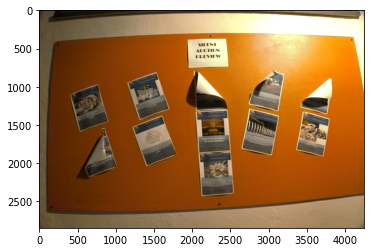

In [56]:
test_sony(U_net)

In [62]:
!cd result_Sony/final && ls

10022_00_100_gt.png	10034_00_250_out.png	10045_00_100_scale.png
10022_00_100_out.png	10034_00_250_scale.png	10087_00_300_gt.png
10022_00_100_scale.png	10045_00_100_gt.png	10087_00_300_out.png
10034_00_250_gt.png	10045_00_100_out.png	10087_00_300_scale.png


In [57]:
def plot_k_model_outputs(k=3, fig_x=20, fig_y=10):
    img_list = os.listdir("result_Sony/final")
    img_list.sort()
    model_path = "result_Sony/final/"
    short_img = 'dataset/Sony/short/'
    fig, axes = plt.subplots(nrows=k, ncols=4, figsize=(fig_x, fig_y))
    [axi.set_axis_off() for axi in axes.ravel()]
    axes[0][0].title.set_text('Short exposure')
    axes[0][1].title.set_text('Long exposure')
    axes[0][2].title.set_text('Model output')
    axes[0][3].title.set_text('Scaled output')
    for i in range(k):
        name = img_list[i*3][:-10]
        gt_raw = rawpy.imread(short_img+name+'0.04s.ARW')
        im = gt_raw.postprocess()
        axes[i][0].imshow(im)
        img = plt.imread(model_path+img_list[i*3])
        axes[i][1].imshow(img)
        img = plt.imread(model_path+img_list[i*3+1])
        axes[i][2].imshow(img)
        img = plt.imread(model_path+img_list[i*3+2])
        axes[i][3].imshow(img)

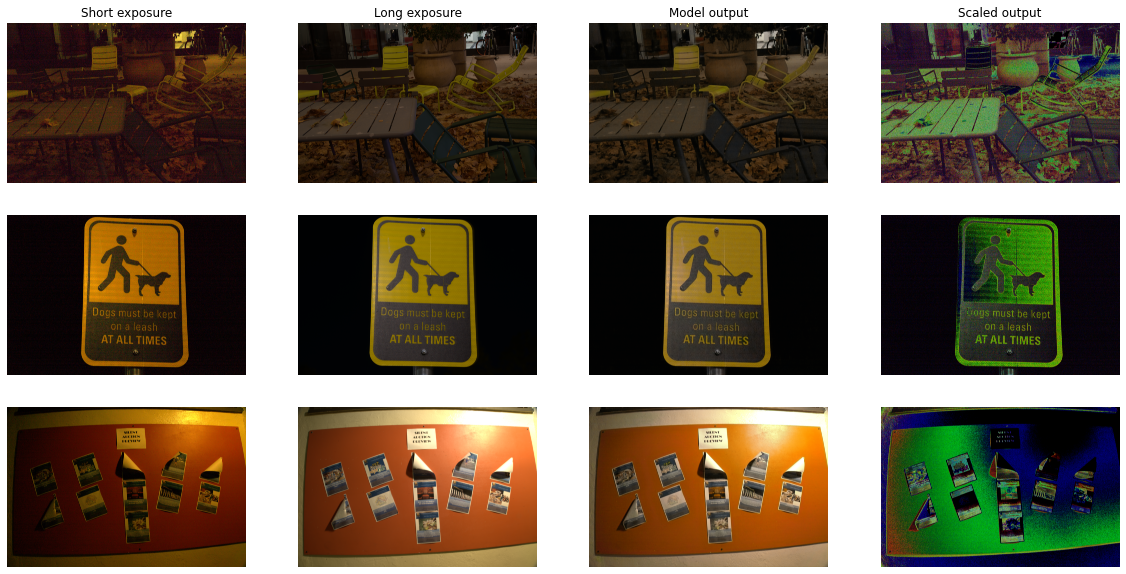

In [59]:
plot_k_model_outputs()